In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch.nn.parameter
import torch.autograd as grad
from torch.nn import functional as F 
import random
from torch.autograd import Function, Variable
from torch.nn import Module, Parameter
import math
import torch.optim
import time
import torchvision
import torchvision.transforms as transforms

/Users/michellezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/michellezhao/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/michellezhao/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/michellezhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/michellezhao/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/michellezhao/anaconda3/lib/python3.6/site-packages/ip

In [100]:
np.random.seed(2)

amp = 100
w = 0.006
b = 20
N = 10000

x = np.arange(N)
data = (amp*np.sin(w*x + b)).astype('float64')
# torch.save(data, open('traindata.pt', 'wb'))
trainX = []
trainY = []
step_size = 15
x_size = 5
y_size = 1
batch_size = 1
for batch in range(batch_size):
    batchX = []
    batchY = []
    for i in range(0, len(data)-15, step_size):
        addx = data[i:i+x_size]
        addy = data[i+x_size:i+x_size+1]
        batchX.append(addx)
        batchY.append(addy)
    trainX.append(batchX)
    trainY.append(batchY)
    
trainX = torch.from_numpy(np.array(trainX))
trainY = torch.from_numpy(np.array(trainY))


x = trainX.float()
y = trainY.float()

In [66]:

def random(*shape):
    return np.random.randn(*shape)


def glorotize(W):
    W *= np.sqrt(6)
    W /= np.sqrt(np.sum(W.shape))
    return W 


def orthogonalize(W):
    W, _, _ = np.linalg.svd(W)
    return W


In [67]:
def recurrent_mask(nclocks, nstates):
    matrix = []
    for c in range(nclocks, 0, -1):
        zero_blocks = np.zeros((nstates, nstates * (nclocks - c)))
        one_blocks = np.ones((nstates, nstates * (c)))
        matrix.append(np.concatenate([zero_blocks, one_blocks], axis=1))
    mask = np.concatenate(matrix, axis=0)
    return mask


def make_schedule(clock_periods, nstates):
    sch = []
    for c in clock_periods:
        for i in range(nstates):
            sch.append(c)
    return sch

class CRNN(nn.Module):
    def __init__(self, dinput, nstates, doutput, clock_periods, full_recurrence=False, learn_state=True, first_layer=False):
        super(CRNN, self).__init__()
        nclocks = len(clock_periods)

        Wi = random(nclocks * nstates, dinput + 1)
        Wh = random(nclocks * nstates, nclocks * nstates + 1)
        Wo = random(doutput, nclocks * nstates + 1)

        H_0 = np.zeros((nclocks * nstates, 1))

        Wi = glorotize(Wi)
        Wh[:, :-1] = orthogonalize(Wh[:, :-1])
        Wo = glorotize(Wo)

        utri_mask = recurrent_mask(nclocks, nstates)
        if not full_recurrence:
            Wh[:,:-1] *= utri_mask


        schedules = make_schedule(clock_periods, nstates)

        self.dinput = dinput
        self.nstates = nstates
        self.doutput = doutput
        self.clock_periods = clock_periods
        self.nclocks = nclocks
        self.Wi = nn.Parameter(torch.from_numpy(Wi).float())
        self.Wh = nn.Parameter(torch.from_numpy(Wh).float())
        self.Wo = nn.Parameter(torch.from_numpy(Wo).float())
        self.H_0 = torch.from_numpy(H_0).float()
        self.utri_mask = utri_mask
        self.schedules = schedules
        self.full_recurrence = full_recurrence
        self.learn_state = learn_state
        self.first_layer = first_layer
        self.H_last = None

    def forward(self, X):

        #input shape of form (seq_length,batch_size,input_dim)
        X = X.transpose(1,2)
        T, n, B = X.size()
        nclocks = self.nclocks
        nstates = self.nstates
        #print "hello"
        Wi = self.Wi
        Wh = self.Wh
        Wo = self.Wo

        Ys = Variable(torch.zeros((T, self.doutput, B)))


        H_prev = Variable(torch.zeros((nclocks * nstates, B)))

        v = torch.cat([self.H_0] * B, 1)

        for t in range(T):
            val = nclocks * nstates
            active = []
            for i in range(len(self.schedules)):
                active.append(int(t%self.schedules[i]==0))
            active = Variable(torch.FloatTensor(active).view(-1,1)).float()
            input = torch.cat([X[t],Variable(torch.ones(1,B))],0).float()
            i_h = torch.mm(Wi,input).float()
            _H_prev = torch.cat([H_prev,Variable(torch.ones((1, B)))],0).float()
            h_h = torch.mm(Wh, _H_prev).float()
            h_new = i_h + h_h
            H_new = F.tanh(h_new).float()
            H = active.expand_as(H_new)*H_new.float()+(1-active.float()).expand_as(H_prev)*H_prev.float()
            _H = torch.cat([H.float(), Variable(torch.ones((1, B)).float())],0).float()
            y = torch.mm(Wo, _H)
            Y = F.tanh(y).float()
            H_prev = H
            Ys[t] = Y
        Ys = Ys.transpose(1,2)
        self.H_last = H
        return Ys,H


In [113]:
class LSTM2(nn.Module): 
    def __init__(self): 

        nn.Module.__init__(self)

#         self.lstm = nn.LSTM(5,10)
        self.lstm = CRNN(5, 1, 10, [1,1], full_recurrence=False, learn_state=True, first_layer=False)
        self.head = nn.Linear(10,1)

    def forward(self,x): 

        outputs, states = self.lstm(x)
        #outputs = outputs.reshape(x.shape[0]*x.shape[1], -1)
        pred = self.head(outputs)
        return pred 


rnn = LSTM2()


epochs = 10000
batch_size = 1
criterion = nn.MSELoss()
mean_loss = 0. 
optimizer = optim.Adam(rnn.parameters(), 1e-3)
for epoch in range(1,epochs+1): 
    optimizer.zero_grad()
    pred = rnn(x)
#     print("pred shape",pred.shape)
#     print("trainY shape:", trainY.shape)
#     shaped_pred = pred.reshape(-1,1)
    loss = criterion((pred), (y))
#        print('loss:', loss.item())
    loss.backward()

    optimizer = optim.Adam(rnn.parameters(), 1e-3)
    optimizer.step()
    mean_loss += loss.item()


    if epoch%100 == 0: 
        print('Epoch: {} | Loss: {:.6f}'.format(epoch, mean_loss))
        mean_loss = 0
        
# print("PREDICTION", pred)
# print("ACUTAL TRAIN Y", trainY)
# ss = 5
# start = 1
# for i in range(20):
#     x = range(start, start+ss+1)
#     start = start+ss+1
#     y = np.append(trainX[0][i].numpy(),trainY[0][i].numpy())
#     y2 = np.append(trainX[0][i].numpy(), pred[0][i].detach().numpy())
#     plt.plot(x,y,'b')
#     plt.plot(x,y2,'r')
# plt.show()

# for i in range(0, len(data)-15, step_size):
#         addx = data[i:i+x_size]
#         addy = data[i+x_size:i+x_size+1]

/Users/michellezhao/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 100 | Loss: 492051.168945
Epoch: 200 | Loss: 482769.141113
Epoch: 300 | Loss: 471552.348633
Epoch: 400 | Loss: 458903.836426
Epoch: 500 | Loss: 445536.600586
Epoch: 600 | Loss: 432021.201172
Epoch: 700 | Loss: 418757.868164
Epoch: 800 | Loss: 405976.633301
Epoch: 900 | Loss: 393728.059814
Epoch: 1000 | Loss: 381966.393066
Epoch: 1100 | Loss: 370639.548828
Epoch: 1200 | Loss: 359689.525146
Epoch: 1300 | Loss: 349063.535889
Epoch: 1400 | Loss: 338719.008789
Epoch: 1500 | Loss: 328626.389404
Epoch: 1600 | Loss: 318764.912842
Epoch: 1700 | Loss: 309117.183838
Epoch: 1800 | Loss: 299671.200195
Epoch: 1900 | Loss: 290420.095459
Epoch: 2000 | Loss: 281358.338867
Epoch: 2100 | Loss: 272480.592773
Epoch: 2200 | Loss: 263782.854004
Epoch: 2300 | Loss: 255261.649658
Epoch: 2400 | Loss: 246915.460693
Epoch: 2500 | Loss: 238742.027832
Epoch: 2600 | Loss: 230736.885498
Epoch: 2700 | Loss: 222897.538086
Epoch: 2800 | Loss: 215223.877686
Epoch: 2900 | Loss: 207715.267578
Epoch: 3000 | Loss: 200

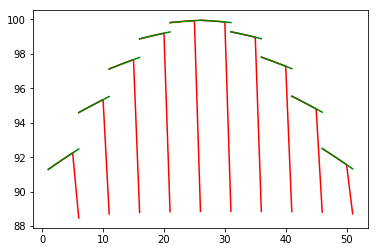

In [114]:
ss = 5

start = 1
for i in range(0,10):
    plt_x = range(start, start+ss+1)
    start = start+ss
    plt_y = np.append(trainX[0][i].numpy(),trainY[0][i].numpy())
    plt_y2 = np.append(trainX[0][i].numpy(), pred[0][i].detach().numpy())

    plt.plot(plt_x,plt_y2,'r')
    plt.plot(plt_x,plt_y,'g')
    
    
plt.show()

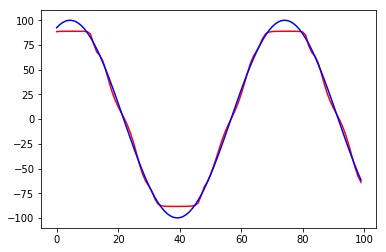

PRED [ 88.473465    88.70326     88.7933      88.832695    88.85064
  88.85738     88.85584     88.843925    88.81031     88.70887
  88.2996      85.99812     76.266716    68.07747     64.57173
  58.751358    49.312775    38.121307    27.736849    19.248838
  12.399739     6.425556     0.50384456  -6.124368   -14.103779
 -23.803356   -34.955864   -46.340767   -56.1133     -63.066605  ]
Y [ 92.47750817  95.52323334  97.79574244  99.27664058  99.95394059
  99.82216002  98.88236559  97.14216449  94.61564285  91.32325166
  87.29164131  82.55344581  77.14701863  71.11612229  64.50957408
  57.38085094  49.78765654  41.79145427  33.45696965  24.85166645
  16.0452006    7.10885632  -1.88503083 -10.86365954 -19.75435199
 -28.48514216 -36.98535839 -45.18619537 -53.02127116 -60.42716447]


In [116]:
new_pred = pred.squeeze(0).squeeze(1).detach().numpy()
new_trainY = trainY.squeeze(0).squeeze(1).detach().numpy()

plt.plot(range(len(new_pred[0:100])), new_pred[0:100], 'r')
plt.plot(range(len(new_trainY[0:100])), new_trainY[0:100], 'b')
plt.show()

print("PRED", new_pred[:30].transpose())
print("Y", new_trainY[:30].transpose())

In [109]:
print(plt_y2)

[ 92.50429232  92.27471106  92.04180792  91.80559128  91.56606966
 -11.68602848]


In [ ]:
print(plt_y)

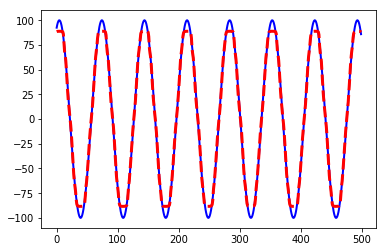

PRED [ 88.473465    88.70326     88.7933      88.832695    88.85064
  88.85738     88.85584     88.843925    88.81031     88.70887
  88.2996      85.99812     76.266716    68.07747     64.57173
  58.751358    49.312775    38.121307    27.736849    19.248838
  12.399739     6.425556     0.50384456  -6.124368   -14.103779
 -23.803356   -34.955864   -46.340767   -56.1133     -63.066605  ]
Y [ 92.47750817  95.52323334  97.79574244  99.27664058  99.95394059
  99.82216002  98.88236559  97.14216449  94.61564285  91.32325166
  87.29164131  82.55344581  77.14701863  71.11612229  64.50957408
  57.38085094  49.78765654  41.79145427  33.45696965  24.85166645
  16.0452006    7.10885632  -1.88503083 -10.86365954 -19.75435199
 -28.48514216 -36.98535839 -45.18619537 -53.02127116 -60.42716447]


In [124]:
new_pred = pred.squeeze(0).squeeze(1).detach().numpy()
new_trainY = trainY.squeeze(0).squeeze(1).detach().numpy()

plt.plot(range(len(new_trainY[0:500])), new_trainY[0:500], 'b', linewidth=2)
plt.plot(range(len(new_pred[0:500])), new_pred[0:500], 'r', linewidth=3, linestyle='--')

plt.show()

print("PRED", new_pred[:30].transpose())
print("Y", new_trainY[:30].transpose())